## todo


- add cm
- add xgboost to custom.json
- add cleaning
- add t-SNE
- add other datasets
- - iris, moon, blobs


## parameters

In [1]:
CLUSTER_ALGO = 'KMeans'
N_CLUSTERS = [21]
CLUSTERS_STD = 1.0
N_P_CLUSTERS = [3,30, 100, 300, 3000]
#N_CLUSTERS_S = N_CLUSTERS[0]

## includes

In [2]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from math import ceil, floor
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons


In [3]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.4              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

## Output registry

In [4]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments


'/docker/photon_experiments'

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


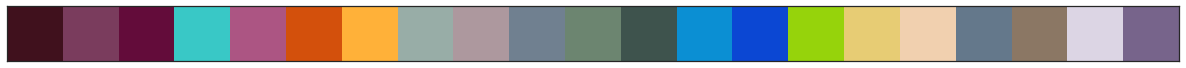

In [5]:

import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
PALLET = ['#40111D', '#7A3C5D', '#630C3A'
                 ,'#39C8C6', '#AC5583', '#D3500C'
                 ,'#FFB139', '#98ADA7', '#AD989E'
                 ,'#708090','#6C8570','#3E534D'
                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#E7CC74','#F1D0AF','#64788B'                 
                 ,'#8B7764','#DCD5E4','#77648B',]
N_PALLET = len(PALLET)
sns.set_palette(PALLET)
sns.palplot(PALLET)


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
#from photonai.base.registry.registry import PhotonRegistry

## function defintions

In [6]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [7]:
def cluster_plot(my_pipe, data_X, n_cluster, PALLET):
    y_pred= my_pipe.predict(data_X)
    data = pd.DataFrame(data_X[:, 0],columns=['x'])
    data['y'] = data_X[:, 1]
    data['labels'] = y_pred
    facet = sns.lmplot(data=data, x='x', y='y', hue='labels', 
                       aspect= 1.0, height=10,
               fit_reg=False, legend=True, legend_out=True)

    customPalette = PALLET*ceil((n_cluster/N_PALLET +2))
    for i, label in enumerate( np.sort(data['labels'].unique())):
        plt.annotate(label, 
                     data.loc[data['labels']==label,['x','y']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=5, weight='bold',
                     color='white',
                     backgroundcolor=customPalette[i]) 

    plt.show()
    return y_pred

In [8]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/custom_elements'

In [9]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [10]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMeans blobs

In [11]:

registry.info(CLUSTER_ALGO)

----------------------------------
Name: KMeans
Namespace: sklearn.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
init                                init='k-means++'                                                           
n_init                              n_init=10                                                                  
max_iter                            max_iter=300                                                               
tol                                 tol=0.0001                                                                 
precompute_distances                precompute_distances='auto'                                                
verbose                             verbose=0                                                                  
random_state                        random_state=Non

('KMeans',
 'sklearn.cluster',
 {'n_clusters': 'n_clusters',
  'init': 'init',
  'n_init': 'n_init',
  'max_iter': 'max_iter',
  'tol': 'tol',
  'precompute_distances': 'precompute_distances',
  'verbose': 'verbose',
  'random_state': 'random_state',
  'copy_x': 'copy_x',
  'n_jobs': 'n_jobs',
  'algorithm': 'algorithm'})

In [12]:
def yield_parameters(n_p_clusters):
    cluster_std = CLUSTERS_STD
    for n_p_cluster in n_p_clusters:
        for n_cluster in N_CLUSTERS:
            n_cluster_std = [cluster_std for k in range(n_cluster)]
            n_samples = [n_p_cluster for k in range(n_cluster)]
            data_X, data_y = make_blobs(n_samples=n_samples,
                                       cluster_std=n_cluster_std, random_state=0)
            yield [data_X, data_y, n_cluster]

In [13]:
def hyper_cluster(cluster_name):
    
    n_p_clusters = N_P_CLUSTERS
    for data_X, data_y,n_cluster  in yield_parameters(n_p_clusters):
        print('n_points:', len(data_y))
        """
        Example script for KMedoids hopt
        """
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')
            
        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=5),
                            inner_cv=KFold(n_splits=10),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name, hyperparameters={
                                                            'n_clusters': IntegerRange(floor(n_cluster*.8)
                                                                                       , ceil(n_cluster*1.1)),
                                                            },random_state=777)

        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred=cluster_plot(my_pipe, X, n_cluster, PALLET)
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

n_points: 63
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

********************************************************
Outer Cross validation Fold 1
********************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMeans": [
        "n_clusters=24"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       0.6099      |      0.3097      |
|   MI   |       0.6486      |      0.3470      |
|  HCV   |       0.9192      |      0.8922      |
|   F

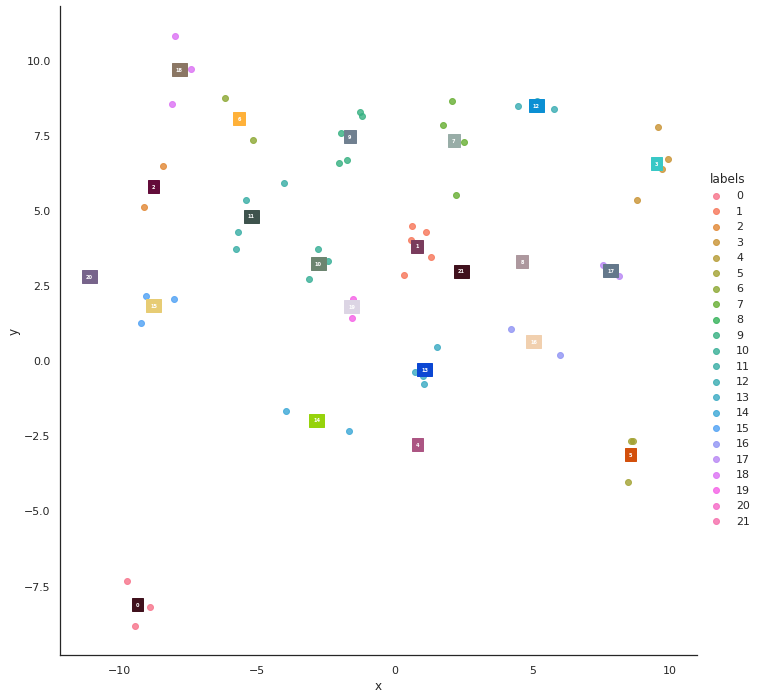

           n_clusters   k
0  KMeans__n_clusters  22
train 
          Mean       STD
2                      
ARI  0.615306  0.020162
FM   0.630560  0.021056
HCV  0.904876  0.013195
MI   0.677122  0.025840
test 
          Mean       STD
2                      
ARI  0.508368  0.336393
FM   0.543063  0.340290
HCV  0.922704  0.039101
MI   0.546768  0.343586
            jaccard_index      0.41237113402061853
               rand_index       0.9708141321044547
            adjrand_index        0.568919248597218
    fowlkes_mallows_index       0.5858330335516624
                 fmeasure        0.583941605839416
             purity_index       0.8095238095238095
     classification_error      0.19047619047619047
        czekanowski_index        0.583941605839416
               dice_index        0.583941605839416
           sorensen_index        0.583941605839416
    rogers_tanimoto_index       0.9432835820895522
          southwood_index       0.7017543859649122
      pearson_correlation    4.43

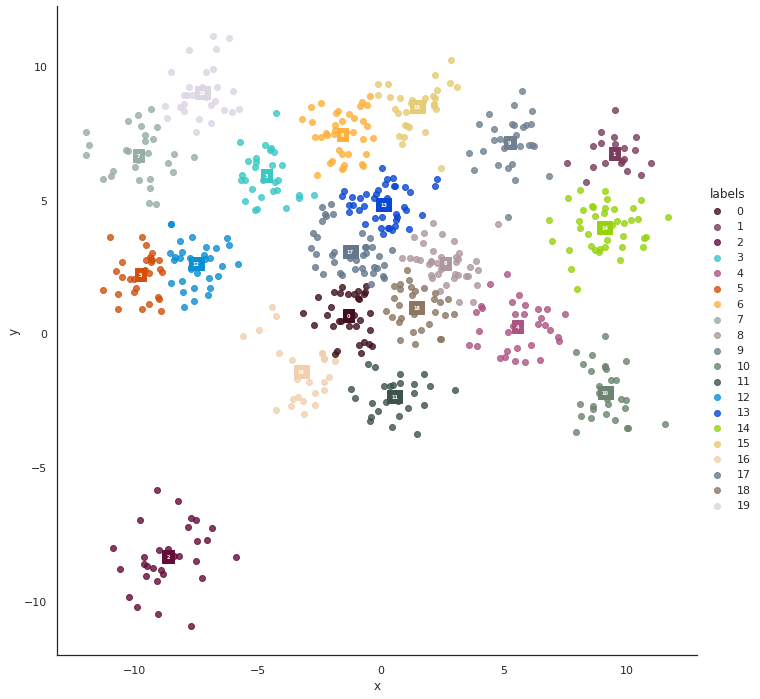

           n_clusters   k
0  KMeans__n_clusters  20
train 
          Mean       STD
2                      
ARI  0.686914  0.026543
FM   0.703933  0.024626
HCV  0.829333  0.010365
MI   0.816807  0.008998
test 
          Mean       STD
2                      
ARI  0.669600  0.030454
FM   0.687864  0.029378
HCV  0.853457  0.008322
MI   0.771209  0.021292
            jaccard_index       0.5461038961038961
               rand_index       0.9717768188356424
            adjrand_index       0.6916276865343329
    fowlkes_mallows_index       0.7070158562901094
                 fmeasure       0.7064258714825703
             purity_index       0.8063492063492064
     classification_error      0.19365079365079363
        czekanowski_index       0.7064258714825703
               dice_index       0.7064258714825703
           sorensen_index       0.7064258714825703
    rogers_tanimoto_index       0.9451030054926446
          southwood_index       1.2031473533619457
      pearson_correlation    3.85

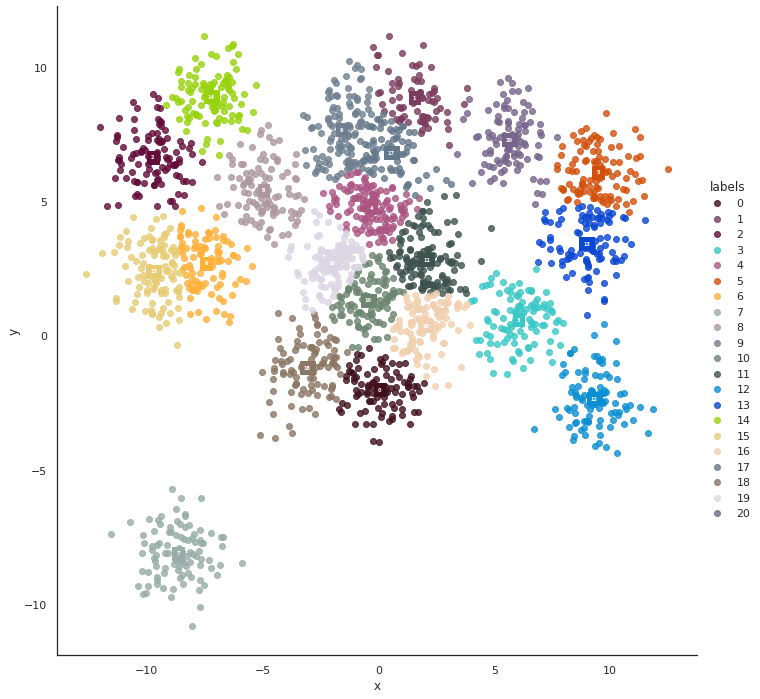

           n_clusters   k
0  KMeans__n_clusters  21
train 
          Mean       STD
2                      
ARI  0.691938  0.008567
FM   0.707497  0.008630
HCV  0.815114  0.002005
MI   0.814752  0.005372
test 
          Mean       STD
2                      
ARI  0.689515  0.023658
FM   0.705582  0.021761
HCV  0.828626  0.017871
MI   0.802880  0.015349
            jaccard_index       0.5425920740424153
               rand_index       0.9718355679575308
            adjrand_index       0.6886973390328988
    fowlkes_mallows_index       0.7034975777979929
                 fmeasure       0.7034809567256938
             purity_index        0.800952380952381
     classification_error      0.19904761904761903
        czekanowski_index       0.7034809567256938
               dice_index       0.7034809567256938
           sorensen_index       0.7034809567256938
    rogers_tanimoto_index        0.945214148311822
          southwood_index       1.1862323393423873
      pearson_correlation    3.13

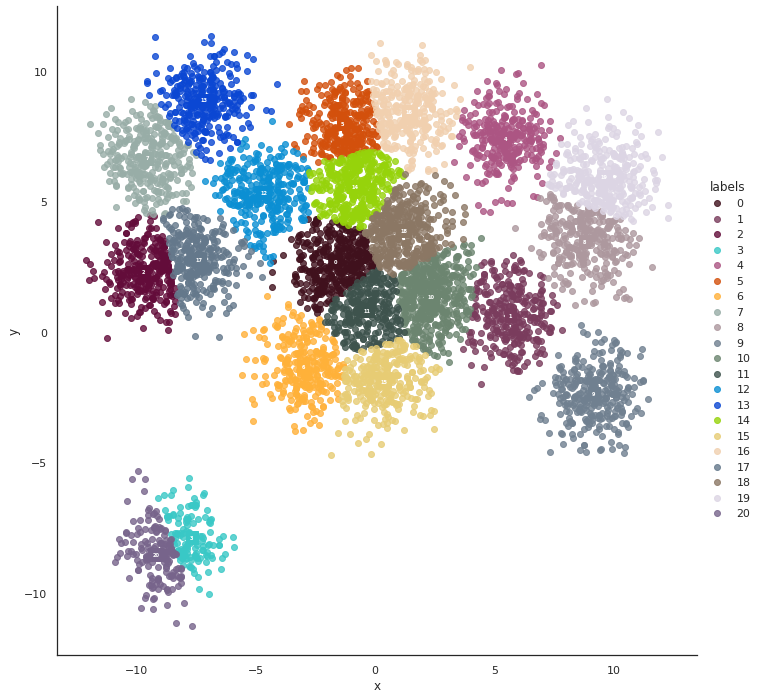

           n_clusters   k
0  KMeans__n_clusters  21
train 
          Mean       STD
2                      
ARI  0.695541  0.006588
FM   0.710675  0.006183
HCV  0.805147  0.002881
MI   0.808735  0.002690
test 
          Mean       STD
2                      
ARI  0.694194  0.024435
FM   0.709327  0.023106
HCV  0.811605  0.013109
MI   0.806588  0.013272
            jaccard_index       0.5352053319057134
               rand_index       0.9705961389688965
            adjrand_index       0.6817985903641667
    fowlkes_mallows_index       0.6974191159947983
                 fmeasure       0.6972426694758036
             purity_index       0.8093650793650794
     classification_error       0.1906349206349206
        czekanowski_index       0.6972426694758036
               dice_index       0.6972426694758036
           sorensen_index       0.6972426694758036
    rogers_tanimoto_index       0.9428720599480732
          southwood_index        1.151487675407549
      pearson_correlation    3.75

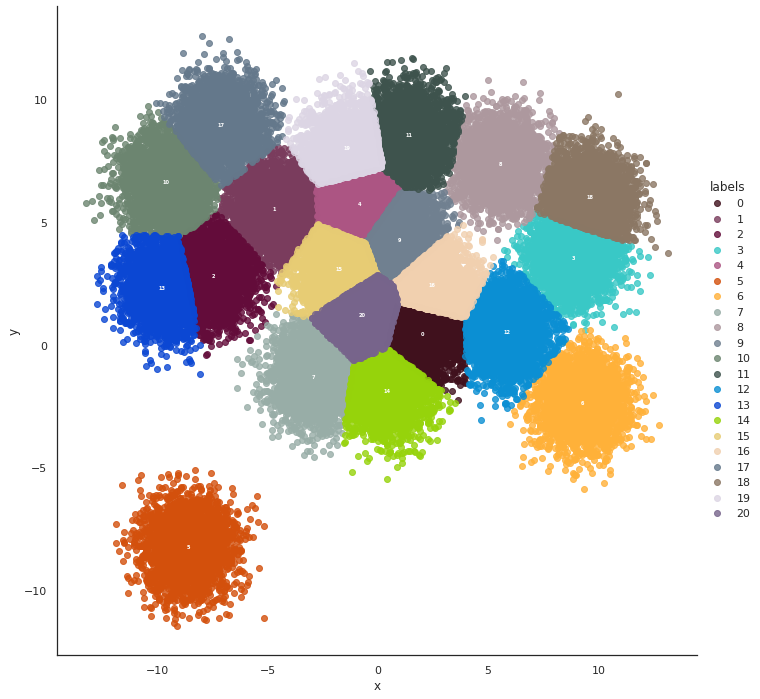

           n_clusters   k
0  KMeans__n_clusters  21
train 
          Mean       STD
2                      
ARI  0.690837  0.009530
FM   0.705867  0.009061
HCV  0.803350  0.002526
MI   0.805720  0.002614
test 
          Mean       STD
2                      
ARI  0.689904  0.010992
FM   0.704997  0.010423
HCV  0.803389  0.002876
MI   0.805103  0.002947
            jaccard_index        0.562244198502978
               rand_index       0.9733019027512908
            adjrand_index       0.7057736190361025
    fowlkes_mallows_index       0.7197906138967136
                 fmeasure       0.7197904131015485
             purity_index       0.8304126984126984
     classification_error      0.16958730158730162
        czekanowski_index       0.7197904131015485
               dice_index       0.7197904131015485
           sorensen_index       0.7197904131015485
    rogers_tanimoto_index       0.9479923118193103
          southwood_index       1.2843786343441592
      pearson_correlation    3.95

In [ ]:
hyper_cluster(CLUSTER_ALGO)

In [ ]:

*-+
*+-=END